# Clean-Label Feature Collision Attacks on a Keras Classifier

In [1]:
# import torch
# a = torch.empty(5, 7, dtype=torch.float)
# print(id(a))
# print(a)

In [2]:
# import numpy as np
# b = torch.tensor(np.random.rand(5,7))
# print(b)
# print(id(b))
# a.data.copy_(b.data)
# print(id(a))
# print(a)

In [3]:
pwd

'/home/shritipriya/adversarial-robustness-toolbox/notebooks'

In this notebook, we will learn how to use ART to run a clean-label feature collision poisoning attack on a neural network trained with Keras. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/1804.00792) by Shafahi, Huang, et. al. 2018.

In [4]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')


import torch
import torch.nn as nn

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)

In [5]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
num_samples_train = 1000
num_samples_test = 1000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Transpose the axes to make input of acceptable format by PyTorchClassifier
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

print("shape of x_train",x_train.shape)
print("shape of y_train",y_train.shape)

shape of x_train (1000, 32, 32, 3)
shape of y_train (1000, 10)


## Load Model to be Attacked

In this example, we using a RESNET50 model pretrained on the CIFAR dataset.

In [6]:
import torch.optim as optim
classifier_model = torch.load('ciafr10_alexnet_pytorch.pt')
# for param in classifier_model.parameters():
#     param.requires_grad = False
classifier_model.eval()
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
classifier = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             preprocessing=(0.5,1),nb_classes=10,input_shape=(32,32,3),loss=criterion,
                             optimizer=optimizer)


In [7]:
classifier_model

Model(
  (_Model__vars): ParameterDict(
      (t_classifier_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x10 (GPU 0)]
      (t_classifier_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 0)]
      (t_scale): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_bias): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_mean): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_var): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_33_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
      (t_conv2d_33_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_31_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
      (t_conv2d_31_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_29_3_kernel_0):

## Choose Target Image from Test Set

shape of target_instance (32, 32, 3)
shape of img_plot (32, 32, 3)
shape of target_instance (1, 32, 32, 3)
true_class: bird
predicted_class: bird


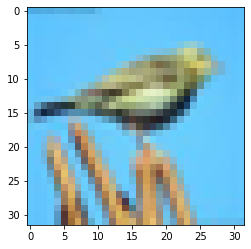

In [8]:
target_class = "bird" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][3], axis=0)
print("shape of target_instance",target_instance[0].shape)
img_plot = target_instance[0]
print("shape of img_plot",img_plot.shape)
fig = plt.imshow(img_plot)
print("shape of target_instance",target_instance.shape)
print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

feature_layer = classifier.layer_names[-2]

In [9]:
classifier.layer_names

['_Model__vars',
 'n_n_conv2d_1',
 'n_n_conv2d_2',
 'n_n_conv2d_3',
 'n_n_batch_normalization_3',
 'n_n_conv2d_4',
 'n_n_conv2d_5',
 'n_n_batch_normalization_5',
 'n_n_conv2d_6',
 'n_n_conv2d_7',
 'n_n_batch_normalization_7',
 'n_n_conv2d_8',
 'n_n_conv2d_9',
 'n_n_batch_normalization_9',
 'n_n_conv2d_10',
 'n_n_conv2d_11',
 'n_n_conv2d_14',
 'n_n_batch_normalization_11',
 'n_n_conv2d_12',
 'n_n_conv2d_13',
 'n_n_batch_normalization_13',
 'n_n_conv2d_15',
 'n_n_conv2d_16',
 'n_n_batch_normalization_15',
 'n_n_conv2d_17',
 'n_n_conv2d_18',
 'n_n_batch_normalization_17',
 'n_n_conv2d_19',
 'n_n_conv2d_20',
 'n_n_batch_normalization_19',
 'n_n_conv2d_21',
 'n_n_conv2d_22',
 'n_n_conv2d_25',
 'n_n_batch_normalization_21',
 'n_n_conv2d_23',
 'n_n_conv2d_24',
 'n_n_batch_normalization_23',
 'n_n_conv2d_26',
 'n_n_conv2d_27',
 'n_n_batch_normalization_25',
 'n_n_conv2d_28',
 'n_n_conv2d_29',
 'n_n_batch_normalization_27',
 'n_n_conv2d_30',
 'n_n_conv2d_31',
 'n_n_batch_normalization_29',
 'n_

In [10]:
# import torchviz

# target_instance = torch.from_numpy(target_instance).cuda()
# y = classifier_model(target_instance)
# print(y)
# torchviz.dot.make_dot(y.mean(), params=dict(classifier_model.named_parameters()))

In [11]:
# pip install graphviz


# Calculate Accuracy of Model

In [12]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))
print("Benign accuracy of the model: {}".format(100*(nb_correct_pred/1000)))

Benign accuracy of the model: 90.60000000000001


## Poison Training Images to Misclassify Test

The attacker wants to make it such that whenever a prediction is made on this particular cat the output will be a horse.

In [13]:
base_class = "frog" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]
print("shape of base_instances",base_instances.shape)
print("shape of base_labels",base_labels.shape)
x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

shape of base_instances (10, 32, 32, 3)
shape of base_labels (10, 10)
New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


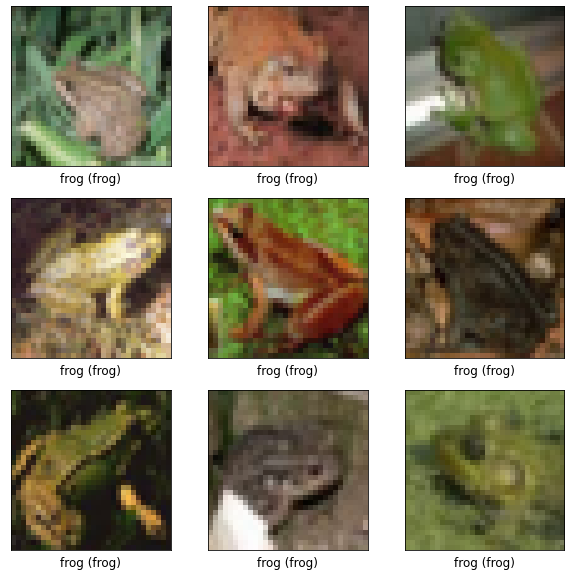

In [14]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

The captions on the images can be read: `predicted label (true label)`

# Computation Graph Visualization

## Creating Poison Frogs

In [15]:
np.expand_dims(base_instances[0],axis=0).shape

(1, 32, 32, 3)

In [16]:
# Keep this fixed
attack = FeatureCollisionAttack(classifier, 
                                target_instance, 
                                feature_layer, 
                                max_iter=10, 
                                similarity_coeff=256,
                                watermark=0.3)
poison, poison_labels = attack.poison(np.expand_dims(base_instances[0],axis=0))
# poison, poison_labels = attack.poison(base_instances)

x max 0.8627451
 x min 0.023529412
Learning rate: 127500.0


Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

tensor(15.9785, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.6773e+12, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(62.7780, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(26.5133, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(53.4138, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(34.9309, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(49.8490, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(67.4224, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(34.7548, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(36.6966, device='cuda:0', grad_fn=<MseLossBackward0>)


In [17]:
a = torch.FloatTensor(3, 2)
a.zero_()


tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [18]:
poison

array([[[[1.        , 0.20000002, 1.        ],
         [1.        , 0.20117648, 0.2647059 ],
         [0.09411766, 1.        , 0.26705885],
         ...,
         [0.1082353 , 1.        , 1.        ],
         [1.        , 0.22470589, 0.29764706],
         [1.        , 0.22588237, 1.        ]],

        [[1.        , 0.2282353 , 1.        ],
         [1.        , 0.22705884, 1.        ],
         [1.        , 1.        , 0.29411766],
         ...,
         [0.10941177, 0.22588237, 1.        ],
         [1.        , 0.22470589, 1.        ],
         [0.10705883, 0.22588237, 0.3       ]],

        [[0.1082353 , 0.23176472, 1.        ],
         [1.        , 1.        , 1.        ],
         [0.10941177, 0.23176472, 0.29882354],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 0.3       ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [0.11411765, 1.        , 1.        ]

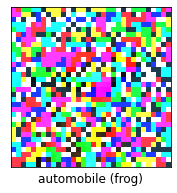

In [19]:
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(poison_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(poison[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')
    break

Notice how the network classifies most of theses poison examples as frogs, and it's not incorrect to do so. The examples look mostly froggy. A slight watermark of the target instance is also added to push the poisons closer to the target class in feature space.

## Training with Poison Images

In [ ]:
import torch.optim as optim
adv_train = np.vstack([x_train, poison])
adv_labels = np.vstack([y_train, poison_labels])
classifier_model.train()
classifier.fit(adv_train, adv_labels, nb_epochs=30, batch_size=4)

## Fooled Network Misclassifies Bird

In [ ]:
fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [ ]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))
print("Benign accuracy of the model: {}".format(100*(nb_correct_pred/1000)))